In [1]:
# Import library
import re
import html
import glob
import numpy as np
import pandas as pd
import joblib
import pickle
from IPython.core.display import display, HTML
from IPython.display import clear_output
from tqdm import tqdm
from os.path import isfile
import warnings 
warnings.filterwarnings('ignore')

# Sklearn library
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLP library
import spacy
spacy.load('en')
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.examples import sentences
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('wordnet')
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\heydi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load in the dataset
df = pd.read_csv('covid_noncomm_use.csv')
df.head()

paper_id  \
0  cd92f91038067e7a10aa27d676ce696e1e4d67ce   
1  bab279da548d8bd363acd5033e9dc54e7dbb7107   
2  71edbd57cdd9af956a12054932e0cbdb87ce1fea   
3  2dfdbf2d6b77426866feaf93486327d372fd27c7   
4  0afa3ea846396533c7ca515968abcfea3f895082   

                                               title  \
0  EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyl...   
1  Effects of school breaks on influenza- like il...   
2  Social Network Characteristics and Body Mass I...   
3             CLINICAL EXPERIMENTAL VACCINE RESEARCH   
4  Bone Marrow Dendritic Cells from Mice with an ...   

                                             authors  \
0  Zhen-Hong Zhu, Wen-Qi Song, Chang-Qing Zhang, ...   
1  Yanhui Chu, Zhenyu Wu, Jiayi Ji, Jingyi Sun, X...   
2  Won Joon Lee, Yoosik Youm, Yumie Rhee, Yeong-R...   
3                                                NaN   
4  Stacey L Burgess, Erica Buonomo, Maureen Carey...   

                                        affiliations  \
0  Zhen-Hong Zhu (Shanghai Jiao Tong University, ...   
1  Yanhui Chu, Zhenyu Wu (Fudan University, Shang...   
2  Won Joon Lee (Yonsei University College of Med...   
3                                                NaN   
4  Stacey L Burgess (Johns Hopkins Bloomberg Scho...   

                                            abstract  \
0  Abstract\n\nMesenchymal stem cells have been w...   
1                                                NaN   
2  Abstract\n\nResearch has shown that obesity ap...   
3                                                NaN   
4  Abstract\n\nThere is an emerging paradigm that...   

                                                text  \
0  Introduction\n\nOsteonecrosis of the femoral h...   
1  INTRODUCTION\n\nSchoolchildren play a major ro...   
2  INTRODUCTION\n\nThe study of the effects of so...   
3  \n\nThere may be many reasons for the signific...   
4  \n\nport neutrophil infiltration in inflammato...   

                                        bibliography  \
0  Avascular necrosis of the femoral head: Vascul...   
1  Estimating household and community transmissio...   
2  The contribution of the social environment to ...   
3  A short history of vaccination, S L Plotkin, S...   
4  WHO/PAHO informal consultation on intestinal p...   

                                         raw_authors  \
0  [{'first': 'Zhen-Hong', 'middle': [], 'last': ...   
1  [{'first': 'Yanhui', 'middle': [], 'last': 'Ch...   
2  [{'first': 'Won', 'middle': ['Joon'], 'last': ...   
3                                                 []   
4  [{'first': 'Stacey', 'middle': ['L'], 'last': ...   

                                    raw_bibliography  
0  {'BIBREF0': {'ref_id': 'b0', 'title': 'Avascul...  
1  {'BIBREF0': {'ref_id': 'b0', 'title': 'Estimat...  
2  {'BIBREF0': {'ref_id': 'b0', 'title': 'The con...  
3  {'BIBREF0': {'ref_id': 'b0', 'title': 'A short...  
4  {'BIBREF0': {'ref_id': 'b0', 'title': 'WHO/PAH...

In [3]:
# Keep the important columns
df = df[['title', 'abstract', 'authors']]
print("Number of rows: " + str(df.shape[0]), "Number of columns: " + str(df.shape[1]))
df.head()

Number of rows: 2490 Number of columns: 3


title  \
0  EXPERIMENTAL AND THERAPEUTIC MEDICINE Dimethyl...   
1  Effects of school breaks on influenza- like il...   
2  Social Network Characteristics and Body Mass I...   
3             CLINICAL EXPERIMENTAL VACCINE RESEARCH   
4  Bone Marrow Dendritic Cells from Mice with an ...   

                                            abstract  \
0  Abstract\n\nMesenchymal stem cells have been w...   
1                                                NaN   
2  Abstract\n\nResearch has shown that obesity ap...   
3                                                NaN   
4  Abstract\n\nThere is an emerging paradigm that...   

                                             authors  
0  Zhen-Hong Zhu, Wen-Qi Song, Chang-Qing Zhang, ...  
1  Yanhui Chu, Zhenyu Wu, Jiayi Ji, Jingyi Sun, X...  
2  Won Joon Lee, Yoosik Youm, Yumie Rhee, Yeong-R...  
3                                                NaN  
4  Stacey L Burgess, Erica Buonomo, Maureen Carey...

In [4]:
# Checking missing values
def check_na(dataframe):
    total = dataframe.isnull().sum()
    parcent = dataframe.isnull().mean()*100
    df_na = pd.concat([total, parcent], axis=1, keys=(['Total NAs', 'NA Parcentage']))
    return df_na

check_na(df)

Total NAs  NA Parcentage
title           291      11.686747
abstract        692      27.791165
authors         276      11.084337

In [5]:
# Remove missing abstracts
df = df[(~(df['abstract'].isna()))]
df['abstract'].shape[0]

1798

In [6]:
# Word count in abstract
df['abstract_word_count'] = df['abstract'].apply(lambda x: len(x.strip().split()))  

# Number of unique words in body
df['abstract_unique_words'] = df['abstract'].apply(lambda x:len(set(str(x).split()))) 
df.sample(3)

title  \
2449  Recombinant Receptor Binding Domain Protein In...   
723   The Return of Lombroso? Ethical Aspects of (Vi...   
140   Localization of the Lys, Asp, Glu, Leu Tetrape...   

                                               abstract  \
2449  Abstract\n\nBackground: Development an effecti...   
723   Abstract\n\nThe vision of legendary criminolog...   
140   Abstract\n\nThe carboxyl-terminal Lys-Asp-Glu-...   

                                                authors  abstract_word_count  \
2449  Jiaming Lan, Yanfeng Yao, Yao Deng, Hong Chen,...                  199   
723                                    Christian Munthe                  174   
140   Gareth Gritiiths, Maria Ericsson, Jacomine Kri...                  357   

      abstract_unique_words  
2449                    141  
723                     113  
140                     213

In [7]:
def word_bar_graph_function(df, column, title, nvals=50):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(nvals), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:nvals])])
    plt.yticks([x + 0.5 for x in range(nvals)], reversed(popular_words_nonstop[0:nvals]))
    plt.title(title)
    plt.show()

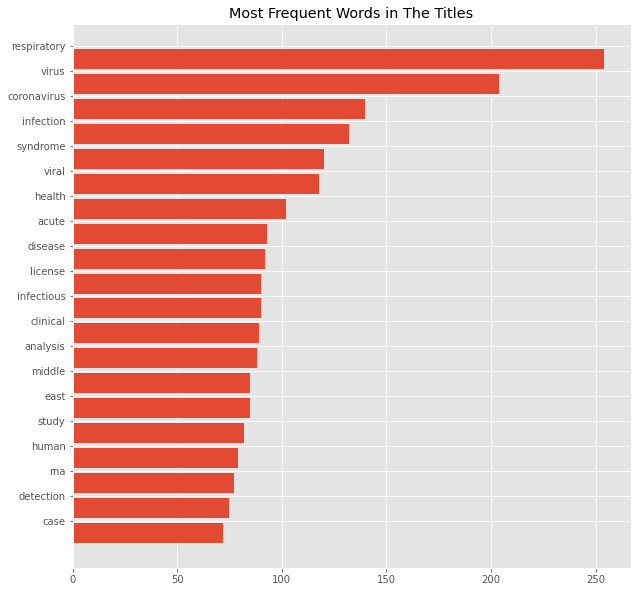

In [8]:
# Show most frequent words in titles
plt.figure(figsize=(10,10))
word_bar_graph_function(df, column='title', 
                        title='Most Frequent Words in The Titles', 
                        nvals=20);

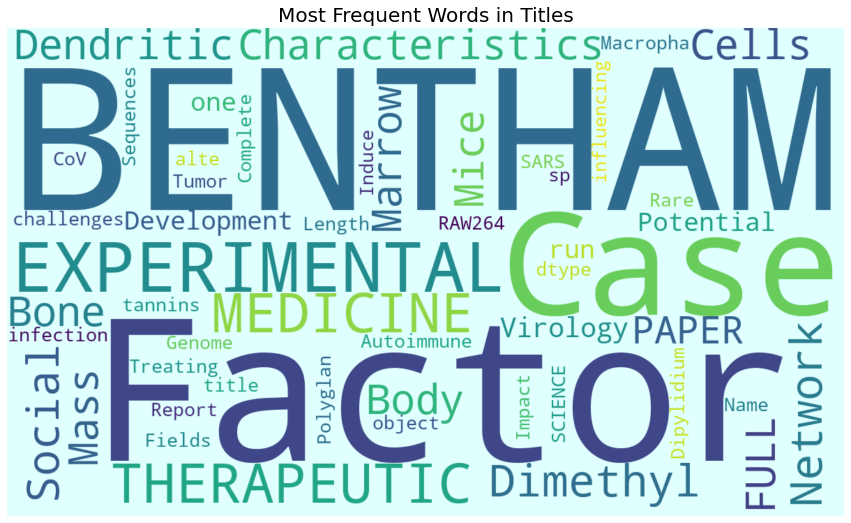

In [9]:
# Word cloud for titles
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'lightcyan',
                      stopwords = None,
                      width = 1200,                      
                      height = 700).generate(str(df['title']))

plt.figure( figsize=(15,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Frequent Words in Titles", fontsize = 20)
plt.axis("off");

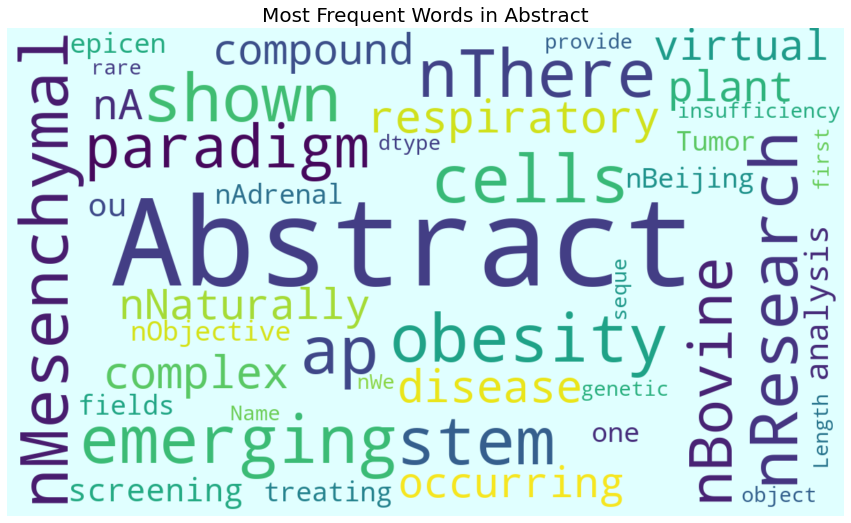

In [10]:
# Word cloud for abstract before cleanup
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'lightcyan',
                      width = 1200,
                      height = 700).generate(str(df['abstract']))

plt.figure( figsize=(15,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Frequent Words in Abstract", fontsize = 20)
plt.axis("off");

In [11]:
# As abstract is the most influencial word, let's remove it
my_word = 'abstract\n'

def clean_text(text):
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in my_word)
    return text
    
df['abstract'] = df['abstract'].apply(clean_text)

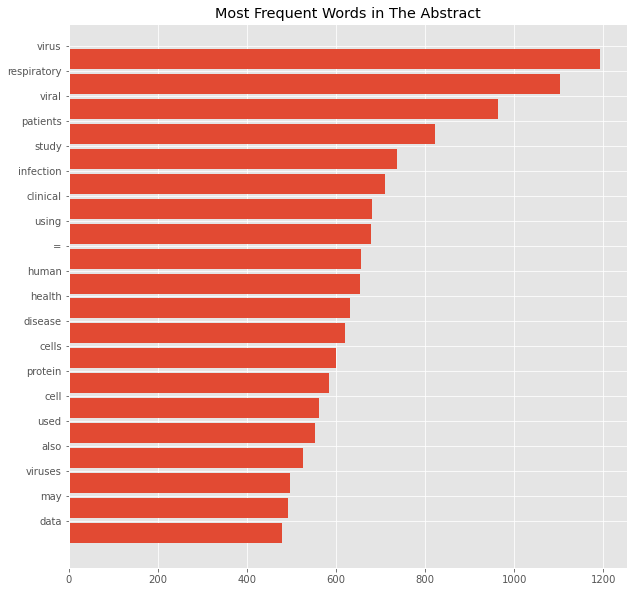

In [12]:
# Show most frequent words in abstract
plt.figure(figsize=(10,10))
word_bar_graph_function(df, column='abstract', 
                        title='Most Frequent Words in The Abstract', 
                        nvals=20);

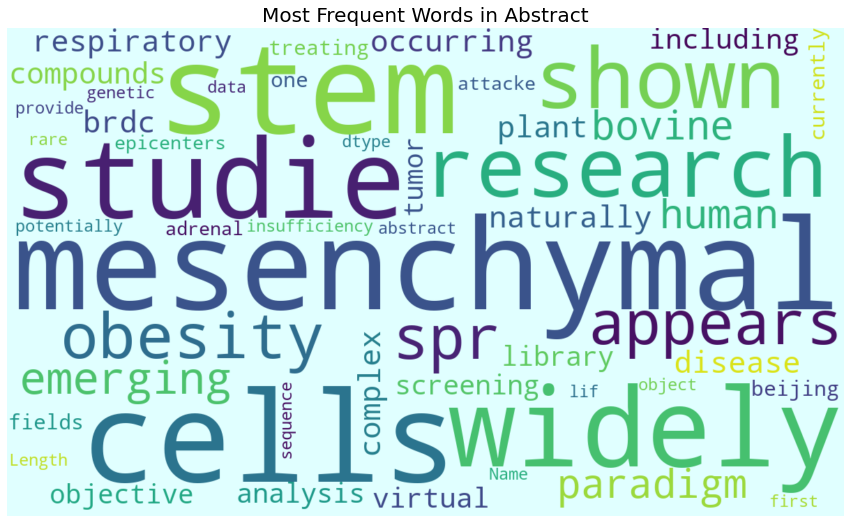

In [13]:
# Word cloud for abstract after cleanup
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'lightcyan',
                      stopwords = None,
                      width = 1200,
                      height = 700).generate(str(df['abstract']))

plt.figure( figsize=(15,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most Frequent Words in Abstract", fontsize = 20)
plt.axis("off");

# Cleaning dataset

In [14]:
corpus = []

#-- initialize the lemmatizer
lem = WordNetLemmatizer()

#-- create a set of stopwords
stop_words = set(stopwords.words("english"))

for text in df['abstract']:
    #-- remove all punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    #-- empty tags 
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    #-- remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ", text)
    #-- make all chars lowercase
    #text = text.lower()
    #-- create a list of words 
    words = text.split()
    text = " ".join([lem.lemmatize(word) for word in words if \
                    word not in stop_words])
    corpus.append(text)
    
# We've now generated a normalized corpus with only word lemmas
corpus[:1]

['mesenchymal stem cell widely studied promote local bone regeneration osteonecrosis femoral head onfh previous study observed dimethyloxaloylglycine dmog enhanced angiogenic osteogenic activity mesenchymal stem cell activating expression hypoxia inducible factor hif thereby improving bone repair capacity mesenchymal stem cell present study investigated whether dmog could increase bone repair capacity adipose derived stem cell ascs treatment onfh western blot analysis performed detect hif protein expression ascs treated different concentration dmog result showed dmog enhanced hif expression ascs dose dependent manner least day furthermore dmog treated ascs transplanted necrotic area rabbit model onfh treat disease four week later micro computed tomography ct quantitative analysis showed necrotic area regenerated dmog treated ascs transplantation group normal ascs transplantation group core decompression group untreated group histological analysis showed transplantation dmog treated asc

# **Word embeddings**

In [15]:
# Define the vectorizer and specify the arguments
vect = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

vect.fit(corpus)

# Transform the vectorizer
features = vect.transform(corpus)

# Transform to a data frame and specify the column names
X = pd.DataFrame(features.toarray(), columns=vect.get_feature_names())
X.head()

abbreviation  ability  able  absence  access  according  ace      acid  \
0           0.0      0.0   0.0      0.0     0.0        0.0  0.0  0.000000   
1           0.0      0.0   0.0      0.0     0.0        0.0  0.0  0.000000   
2           0.0      0.0   0.0      0.0     0.0        0.0  0.0  0.000000   
3           0.0      0.0   0.0      0.0     0.0        0.0  0.0  0.037247   
4           0.0      0.0   0.0      0.0     0.0        0.0  0.0  0.000000   

   acquired  across  ...  worker     world  worldwide  would      year  \
0       0.0     0.0  ...     0.0  0.000000   0.000000    0.0  0.000000   
1       0.0     0.0  ...     0.0  0.000000   0.000000    0.0  0.038353   
2       0.0     0.0  ...     0.0  0.075245   0.000000    0.0  0.000000   
3       0.0     0.0  ...     0.0  0.000000   0.092276    0.0  0.030712   
4       0.0     0.0  ...     0.0  0.000000   0.000000    0.0  0.000000   

   year old  yet  young  zikv  zoonotic  
0       0.0  0.0    0.0   0.0       0.0  
1       0.0  0.0    0.0   0.0       0.0  
2       0.0  0.0    0.0   0.0       0.0  
3       0.0  0.0    0.0   0.0       0.0  
4       0.0  0.0    0.0   0.0       0.0  

[5 rows x 1000 columns]

# **N-grams**

In [26]:
# Function for n-grams
def count_ngrams(dataframe, column, begin_ngram, end_ngram):
    # adapted from https://stackoverflow.com/questions/36572221/how-to-find-ngram-frequency-of-a-column-in-a-pandas-dataframe
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(df[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency', ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

In [27]:
# Evaluate title 3-grams
three_gram_title = count_ngrams(df,'title',3,3)
three_gram_title[0:20]

frequency                             ngram
by nc nd                                 91                          by nc nd
nc nd license                            88                     nc nd license
licenses by nc                           87                    licenses by nc
org licenses by                          87                   org licenses by
http creativecommons org                 87          http creativecommons org
creativecommons org licenses             87      creativecommons org licenses
nd license http                          85                   nd license http
license http creativecommons             85      license http creativecommons
middle east respiratory                  83           middle east respiratory
east respiratory syndrome                82         east respiratory syndrome
respiratory syndrome coronavirus         63  respiratory syndrome coronavirus
of middle east                           29                    of middle east
severe acute respiratory                 20          severe acute respiratory
acute respiratory syndrome               18        acute respiratory syndrome
respiratory syncytial virus              18       respiratory syncytial virus
in patients with                         14                  in patients with
in dogs with                             13                      in dogs with
forum infectious diseases                13         forum infectious diseases
open forum infectious                    13             open forum infectious
analysis of the                          12                   analysis of the

In [28]:
# Plot most frequent title 3-gram distribution
fig = px.bar(three_gram_title.nlargest(10, 'frequency'), 
             x="frequency", 
             y="ngram",
             title='Most Common 3 Words in Titles',
             orientation='h')
fig.show()

In [29]:
# Evaluate abstract 3-grams
three_gram_abs = count_ngrams(df,'abstract',3,3)
three_gram_abs[0:20]

frequency                             ngram
as well as                              211                        as well as
middle east respiratory                 148           middle east respiratory
east respiratory syndrome               147         east respiratory syndrome
respiratory syndrome coronavirus        144  respiratory syndrome coronavirus
in this study                           133                     in this study
the development of                      130                the development of
severe acute respiratory                130          severe acute respiratory
the presence of                         129                   the presence of
of mers cov                             125                       of mers cov
acute respiratory syndrome              123        acute respiratory syndrome
polymerase chain reaction               106         polymerase chain reaction
one of the                              105                        one of the
respiratory syncytial virus              97       respiratory syncytial virus
the present study                        95                 the present study
the number of                            89                     the number of
coronavirus mers cov                     88              coronavirus mers cov
the role of                              87                       the role of
of this study                            83                     of this study
the use of                               83                        the use of
syndrome coronavirus mers                81         syndrome coronavirus mers

In [30]:
# Plot most frequent abstract 3-gram distribution
fig = px.bar(three_gram_abs.nlargest(10, 'frequency'), 
             x="frequency", 
             y="ngram",
             title='Most Common 3 Words in Abstract',
             orientation='h')
fig.show()

# **Topic medoling using LDA**

In [31]:
# Include multiple word in the tokenization
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [32]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [33]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [34]:
df['tokens'] = df.apply(lambda x: prepare_text_for_lda(x['abstract']), axis=1)
text_data = list(df['tokens'])

In [35]:
# Data dictionary
dictionary = corpora.Dictionary(text_data)

# Corpus and tf-idf
corpus = [dictionary.doc2bow(text) for text in text_data]

# Pickle the corpus
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

## 10 topics

In [36]:
# Fitting lda model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics = 10, 
                                           id2word=dictionary, 
                                           update_every=1,
                                           passes=10, 
                                           iterations =20,
                                           random_state=1,
                                           alpha='auto')

ldamodel.save('model10.gensim')

topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.011*"calf" + 0.006*"virus" + 0.006*"frameshifting" + 0.005*"strain" + 0.005*"sequence" + 0.005*"isolate" + 0.004*"between" + 0.004*"diarrhea" + 0.004*"herd" + 0.004*"study"')
(1, '0.018*"protein" + 0.013*"cell" + 0.008*"membrane" + 0.008*"virus" + 0.007*"expression" + 0.007*"domain" + 0.006*"which" + 0.006*"study" + 0.005*"activity" + 0.005*"these"')
(2, '0.010*"sequence" + 0.006*"antibody" + 0.005*"study" + 0.005*"genome" + 0.005*"result" + 0.004*"increase" + 0.004*"protein" + 0.004*"these" + 0.004*"expression" + 0.004*"cell"')
(3, '0.011*"disease" + 0.011*"health" + 0.008*"infection" + 0.008*"outbreak" + 0.007*"virus" + 0.007*"transmission" + 0.006*"control" + 0.006*"case" + 0.005*"coronavirus" + 0.005*"public"')
(4, '0.011*"health" + 0.006*"gene" + 0.006*"human" + 0.005*"identify" + 0.005*"camel" + 0.005*"infection" + 0.005*"animal" + 0.005*"sequence" + 0.005*"transmission" + 0.005*"disease"')
(5, '0.040*"virus" + 0.020*"respiratory" + 0.016*"infection" + 0.012*"viral" + 0.00

## Coherence values

In [37]:
# Function for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics = 10, 
                                           id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=text_data, 
                                                        start=2, limit=40, step=6)

In [39]:
# Print the coherence scores
for m, cv in zip(range(2, 40, 6), coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2955
Num Topics = 8  has Coherence Value of 0.309
Num Topics = 14  has Coherence Value of 0.3083
Num Topics = 20  has Coherence Value of 0.3017
Num Topics = 26  has Coherence Value of 0.2987
Num Topics = 32  has Coherence Value of 0.304
Num Topics = 38  has Coherence Value of 0.3038


## Dominant topics in each sentence

In [40]:
# Dominant topics in each sentence

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.5650   
1            1             4.0              0.5347   
2            2             3.0              0.7988   
3            3             5.0              0.3777   
4            4             3.0              0.6031   
5            5             9.0              0.3919   
6            6             2.0              0.7088   
7            7             7.0              0.8267   
8            8             2.0              0.9942   
9            9             4.0              0.5387   

                                            Keywords  \
0  sequence, antibody, study, genome, result, inc...   
1  health, gene, human, identify, camel, infectio...   
2  disease, health, infection, outbreak, virus, t...   
3  virus, respiratory, infection, viral, human, c...   
4  disease, health, infection, outbreak, virus, t...   
5  vaccine, disease, study, method, base, these, ...   
6  sequence, antibody, study, genome, result, inc...   
7  patient, respiratory, clinical, virus, infecti...   
8  sequence, antibody, study, genome, result, inc...   
9  health, gene, human, identify, camel, infectio...   

                                                Text  
0  [mesenchymal, cell, widely, study, promote, lo...  
1  [research, show, obesity, appear, spread, thro...  
2  [there, emerge, paradigm, human, microbiome, c...  
3  [bovine, respiratory, disease, complex, freque...  
4  [naturally, occur, plant, compound, include, t...  
5  [purpose, study, represent, current, epidemiol...  
6  [emerge, picture, nature, immune, system, acro...  
7  [increase, autoantibody, reactivity, plasma, m...  
8  [neutrophil, immune, cell, crucial, protect, a...  
9  [moraxella, catarrhalis, ubiquitous, human, sp...

## Most representative document for each topic

In [41]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9964   
1        1.0              0.9983   
2        2.0              0.9973   
3        3.0              0.9981   
4        4.0              0.9966   
5        5.0              0.9972   
6        6.0              0.9983   
7        7.0              0.9979   
8        8.0              0.9994   
9        9.0              0.9981   

                                            Keywords  \
0  calf, virus, frameshifting, strain, sequence, ...   
1  protein, cell, membrane, virus, expression, do...   
2  sequence, antibody, study, genome, result, inc...   
3  disease, health, infection, outbreak, virus, t...   
4  health, gene, human, identify, camel, infectio...   
5  virus, respiratory, infection, viral, human, c...   
6  protein, virus, viral, infection, vaccine, cel...   
7  patient, respiratory, clinical, virus, infecti...   
8  patient, study, disease, infection, treatment,...   
9  vaccine, disease, study, method, base, these, ...   

                                                Text  
0  [hallmark, translation, human, immunodeficienc...  
1  [abstracl, expression, hepatitis, surface, ant...  
2  [objective, increase, hepatic, expression, dip...  
3  [‫محمد‬, ‫األمير‬, ‫مطار‬, ‫العاملني‬, ‫وسلوك‬...  
4  [background, micro, organism, transmit, verteb...  
5  [severe, sometimes, fatal, respiratory, diseas...  
6  [piuttosto, articoli, eccellenti, termine, pro...  
7  [‫االستعداد‬, ‫يخص‬, ‫فيما‬, ‫واملمارسات‬, ‫وا...  
8  [blautia, 0.008, significantly, decrease, hira...  
9  [introduction, there, little, research, emerge...

## Topic distribution across documents

In [42]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0.0             0.0  calf, virus, frameshifting, strain, sequence, ...   
1.0             1.0  protein, cell, membrane, virus, expression, do...   
2.0             2.0  sequence, antibody, study, genome, result, inc...   
3.0             3.0  disease, health, infection, outbreak, virus, t...   
4.0             4.0  health, gene, human, identify, camel, infectio...   
5.0             5.0  virus, respiratory, infection, viral, human, c...   
6.0             6.0  protein, virus, viral, infection, vaccine, cel...   
7.0             7.0  patient, respiratory, clinical, virus, infecti...   
8.0             8.0  patient, study, disease, infection, treatment,...   
9.0             9.0  vaccine, disease, study, method, base, these, ...   

     Num_Documents  Perc_Documents  
0.0             74          0.0412  
1.0            254          0.1413  
2.0            101          0.0562  
3.0            204          0.1135  
4.0            131          0.0729  
5.0            271          0.1507  
6.0            144          0.0801  
7.0            123          0.0684  
8.0            273          0.1518  
9.0            223          0.1240

## Save the topic model

In [43]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')

## Model perplexity measure

In [44]:
# Compute Perplexity -- a measure of how good the model is. A low score is good.
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  

# Compute Coherence Score (high value is good)
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.09390872992496

Coherence Score:  0.4204411029031762


## Visualizing 10 topics

In [45]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')

# Visual graph
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)

# lda matching by words vs matching by documents. Document may contains multiple topics and words. 
pyLDAvis.display(lda_display10)